# Wolf, goat and cabbage problem

River crossing puzzle.

There is a wolf, farmer, goat and cabbage. They need go from one side of the river to the other side. There are certain rules in place.

The wolf and the goat cannot be together when the farmer is away.
The goat and the cabbage cannot be together when the farmer is away.

How do we find the path to letting all of them cross the river?

In [49]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from enum import Enum
from copy import deepcopy
from pprint import pprint

## Defining the game

In [50]:
class Location(Enum):
    A = 1
    B = 2

class State:
    man = Location.A
    wolf = Location.A
    goat = Location.A
    cabbage = Location.A

    def __init__(self, man, wolf, goat, cabbage):
        self.man = man
        self.wolf = wolf
        self.goat = goat
        self.cabbage = cabbage

    def __eq__(self, other):
        if (
            self.man == other.man
            and self.wolf == other.wolf
            and self.goat == other.goat
            and self.cabbage == other.cabbage
        ):
            return True
        return False

    def __hash__(self):
        return hash((self.man, self.wolf, self.goat, self.cabbage))

    def __str__(self):
        s = ""
        for name, entity in zip(["M", "W", "G", "C"], [self.man, self.wolf, self.goat, self.cabbage]):
            if entity == Location.A:
                s += name
        s += " | "
        for name, entity in zip(["M", "W", "G", "C"], [self.man, self.wolf, self.goat, self.cabbage]):
            if entity == Location.B:
                s += name
        return s


    def __repr__(self):
        s = ""
        for name, entity in zip(["M", "W", "G", "C"], [self.man, self.wolf, self.goat, self.cabbage]):
            if entity == Location.A:
                s += name
        s += " | "
        for name, entity in zip(["M", "W", "G", "C"], [self.man, self.wolf, self.goat, self.cabbage]):
            if entity == Location.B:
                s += name
        return s



Let's first define the start and end state

In [51]:
initial_state = State(Location.A, Location.A, Location.A, Location.A)
goal_state = State(Location.B, Location.B, Location.B, Location.B)

In [52]:
class Graph:
    def __init__(self):
        self.edges = {}

    def neighbors(self, node):
        return self.edges[node]


graph = Graph()

In [53]:
def is_valid(state):
    if state.goat == state.cabbage and state.man != state.goat:
        return False
    if state.wolf == state.goat and state.man != state.wolf:
        return False
    return True


def next_states(state):
    current = state.man
    next = Location.B if state.man == Location.A else Location.A
    moves = []
    # Include the farmer moving by himself
    alone = deepcopy(state)
    alone.man = next
    moves.append(alone)

    for thing in ["goat", "wolf", "cabbage"]:
        if getattr(state, thing) == state.man:
            copy = deepcopy(state)
            setattr(copy, thing, next)
            copy.man = next
            moves.append(copy)

    return moves

In [54]:
# Encode all states into the graph
def encode(state):
    if state == goal_state:
        return
    if state not in graph.edges.keys():
        nodes = next_states(state)
        graph.edges[state] = nodes
        for node in nodes:
            if is_valid(node):
                encode(node)

In [55]:
encode(initial_state)

In [56]:
# Check that graph is encoded
#{MWGC | : [WGC | M, WG | MC, WC | MG, GC | MW],
pprint(graph.edges)

{C | MWG: [MC | WG, MGC | W, MWC | G],
 MGC | W: [GC | MW, C | MWG, G | MWC],
 G | MWC: [MG | WC, MWG | C, MGC | W],
 MWG | C: [WG | MC, W | MGC, G | MWC],
 MG | WC: [G | MWC,  | MWGC],
 W | MGC: [MW | GC, MWG | C, MWC | G],
 WC | MG: [MWC | G, MWGC | ],
 MWGC | : [WGC | M, WC | MG, GC | MW, WG | MC],
 MWC | G: [WC | MG, C | MWG, W | MGC]}


# Show graph

In [57]:
edges = set([])
for k, v in graph.edges.items():
    for e in v:
        edges.add((str(k), str(e)))
edges = list(edges)

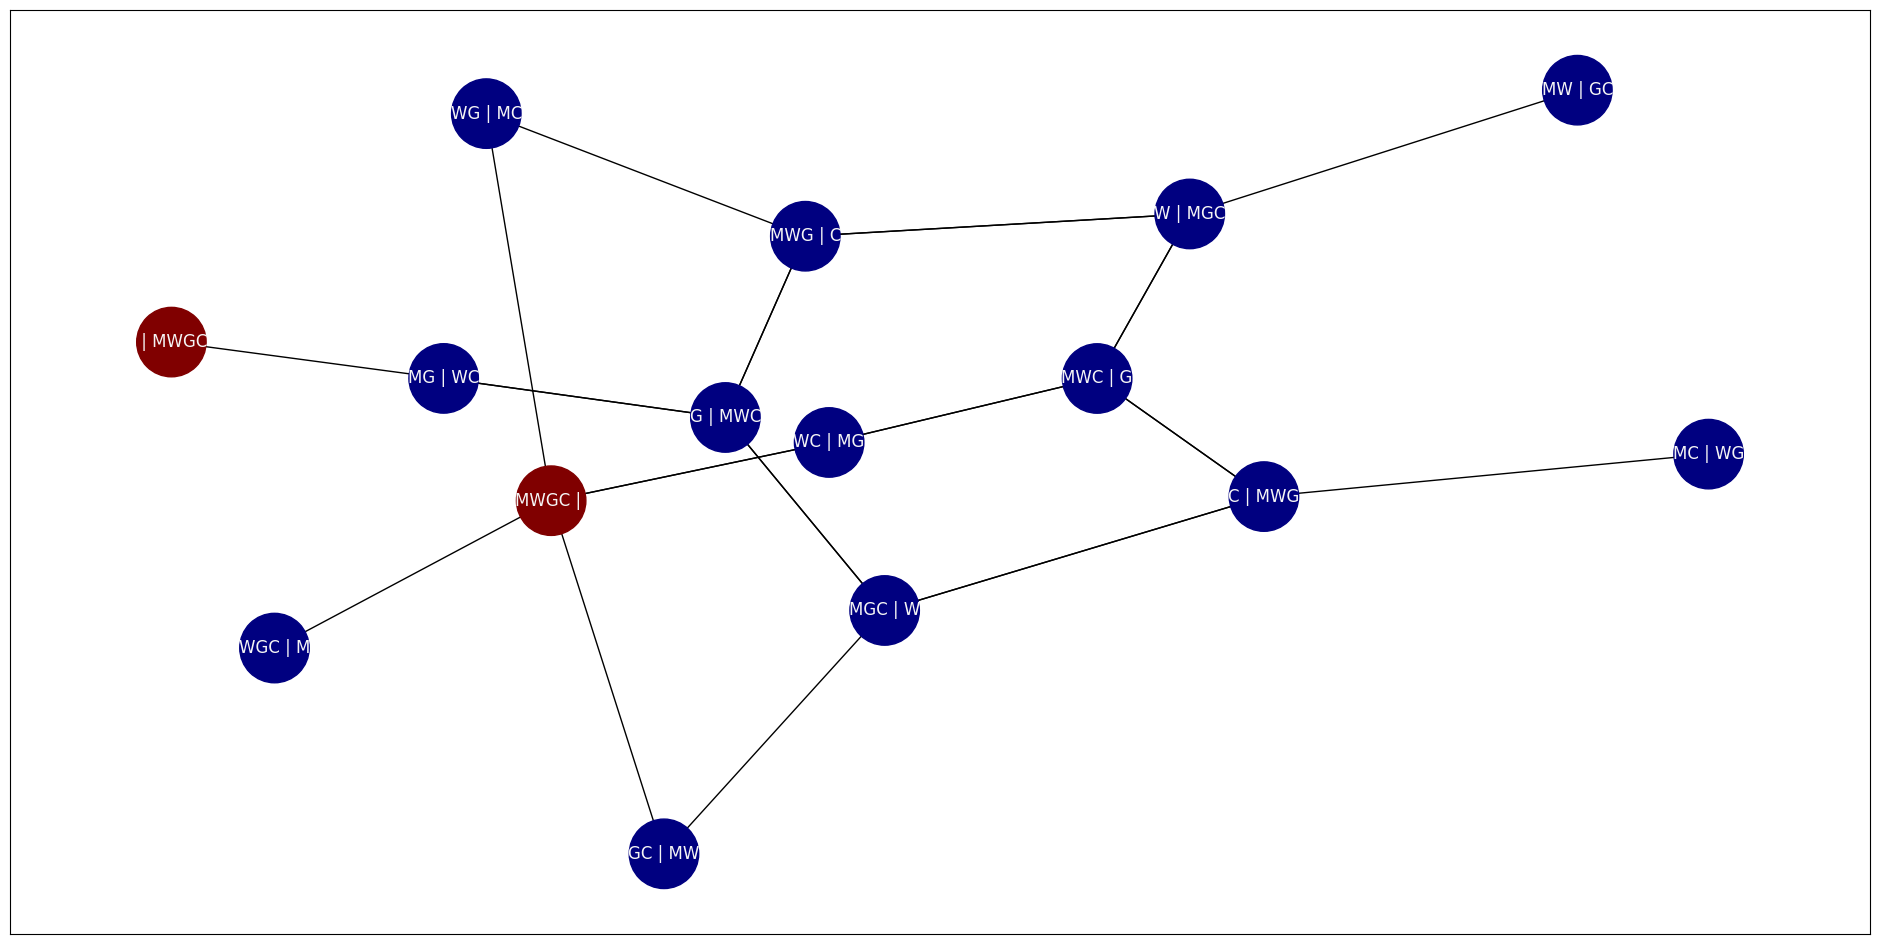

In [58]:
G = nx.DiGraph()
G.add_edges_from(edges)

val_map = {
    'MWGC | ' : 1.0,
    ' | MWGC' : 1.0,
}
values = [val_map.get(node, 0.25) for node in G.nodes()]
f, axes = plt.subplots(1, 1, figsize=(24, 12))

pos = nx.spring_layout(G)
# Draw the circle nodes
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_color=values, node_size = 2500)
# Draw the node labels
nx.draw_networkx_labels(G, pos, font_color='whitesmoke')
nx.draw_networkx_edges(G, pos, edgelist=edges, arrows=False)
plt.show()

# BFS

In [59]:
def bfs(root):
    queue = [[root]]
    visited = set([])
    iterations = 0
    while len(queue) != 0:
        path = queue.pop(0)
        iterations += 1
        node = path[-1]
        if node == goal_state:
            return (iterations, path)
        if node in graph.edges:
            for edge in graph.edges[node]:
                if edge not in visited:
                    visited.add(edge)
                    new_path = list(path)
                    new_path.append(edge)
                    queue.append(new_path)

In [60]:
bfs(initial_state)

(16, [MWGC | , WC | MG, MWC | G, C | MWG, MGC | W, G | MWC, MG | WC,  | MWGC])

With **Breath First Search** we enqueue the next available nodes and explore the frontier nodes with incerasing depth level

# DFS

In [61]:
def dfs(root):
    stack = [[root]]
    visited = set([])
    iterations = 0
    while len(stack) != 0:
        path = stack.pop(len(stack)-1)
        iterations += 1
        node = path[-1]
        visited.add(node)
        if node == goal_state:
            return (iterations, path)
        if node in graph.edges:
            for edge in graph.edges[node]:
                if edge not in visited:
                    visited.add(edge)
                    new_path = list(path)
                    new_path.append(edge)
                    stack.append(new_path)

In [62]:
dfs(initial_state)

(11, [MWGC | , WC | MG, MWC | G, W | MGC, MWG | C, G | MWC, MG | WC,  | MWGC])

With **Depth First Search(DFS)**, we explore each frontier node depth wise. 

As can be seen by the solution cost = 11, it is faster than breath first search

# Iterative deepening search

In [63]:
def iterative_deepening_search(start_state, goal_state, max_depth):
    nodes_visited = 0

    for depth in range(max_depth):
        result, visited = depth_limited_search(start_state, goal_state, depth)
        nodes_visited = visited
        
        print("Max Depth:", depth, result, "Nodes visited =", nodes_visited)
        if result:
            return result, nodes_visited

    return None, nodes_visited

def depth_limited_search(state, goal_state, depth):
    visited = set()

    return recursive_dls(state, goal_state, depth, visited), len(visited)

def recursive_dls(state, goal_state, depth, visited):
    visited.add(state)

    if state == goal_state:
        return [state]

    if depth == 0:
        return None

    if state in graph.edges:
        for move in graph.edges[state]:
            if move not in visited:
                result = recursive_dls(move, goal_state, depth - 1, visited)
                if result:
                    result.insert(0, state)
                    return result

    return None

With **iterative deepening search** we increase the max depth of the breadth first search to a defined cut off. We do this to avoid infinite searching but the **limitation** is that we may not find a solution for a low max depth. This an optimisation technique for BFS in the event the search graph is very **deep**

We can see with a higher depth, we visit more nodes.

In [66]:
iterative_deepening_search(initial_state, goal_state, 9)

Max Depth: 0 None Nodes visited = 1
Max Depth: 1 None Nodes visited = 5
Max Depth: 2 None Nodes visited = 6
Max Depth: 3 None Nodes visited = 8
Max Depth: 4 None Nodes visited = 12
Max Depth: 5 None Nodes visited = 13
Max Depth: 6 None Nodes visited = 14
Max Depth: 7 [MWGC | , WC | MG, MWC | G, C | MWG, MGC | W, G | MWC, MG | WC,  | MWGC] Nodes visited = 11


([MWGC | , WC | MG, MWC | G, C | MWG, MGC | W, G | MWC, MG | WC,  | MWGC], 11)

# Constraint forward checking

In [64]:
def constriant_forwardchecking(root):
    stack = [[root]]
    visited = set([])
    iterations = 0
    while len(stack) != 0:
        path = stack.pop(len(stack)-1)
        iterations += 1
        node = path[-1]
        visited.add(node)
        if node == goal_state:
            return (iterations, path)
        if node in graph.edges:
            for edge in graph.edges[node]:
                if edge not in visited and is_valid(edge):
                    visited.add(edge)
                    new_path = list(path)
                    new_path.append(edge)
                    stack.append(new_path)

In [65]:
constriant_forwardchecking(initial_state)

(9, [MWGC | , WC | MG, MWC | G, W | MGC, MWG | C, G | MWC, MG | WC,  | MWGC])

With **constraint forward checking**, we check if the next available nodes are valid states before adding to the frontier for exploration, as seen with the cost=9, we only explored 9 nodes to reach solution 

# Uniform Cost Search

In [67]:
def ucs(root):
    queue = [(0, [root])]
    visited = set()
    iterations = 0
    while queue:
        queue.sort(key = lambda x: x[0])
        cost, path = queue.pop(0)
        iterations += 1
        node = path[-1]
        if node == goal_state:
            return (iterations, cost, path)
        if node in graph.edges:
            for edge in graph.edges[node]:
                if edge not in visited:
                    visited.add(edge)
                    new_path = list(path)
                    new_path.append(edge)
                    new_cost = cost + 1 
                    queue.append((new_cost, new_path))

In [68]:
ucs(initial_state)

(16,
 7,
 [MWGC | , WC | MG, MWC | G, C | MWG, MGC | W, G | MWC, MG | WC,  | MWGC])

With **Uniform Cost Search**, we assign an "edge cost" to each path. We prioritise the path with the lowest "edge cost".

# Greedy Search

In [69]:
def h(state):
        count = 0
        if state.wolf == Location.A:
            count += 1
        if state.goat == Location.A:
            count += 1
        if state.cabbage == Location.A:
            count += 1
        if state.man == Location.A:
            count += 1
        return count

def greedy_search(root):
    queue = [(h(root), [root])]
    visited = set()
    iterations = 0
    while queue:
        queue.sort(key = lambda x: x[0])
        _, path = queue.pop(0)
        iterations += 1
        node = path[-1]
        if node == goal_state:
            return (iterations, path)
        if node in graph.edges:
            for edge in graph.edges[node]:
                if edge not in visited:
                    visited.add(edge)
                    new_path = list(path)
                    new_path.append(edge)
                    queue.append((h(edge), new_path))

In [70]:
greedy_search(initial_state)

(14, [MWGC | , WC | MG, MWC | G, C | MWG, MGC | W, G | MWC, MG | WC,  | MWGC])

With **Greedy Search**, we assign a "cost" to each path based on a heuristic function. We prioritise the path with the lowest "cost".
The heuristic function decides the proximity of a node to the goal state. 
Here, it is decided by the number of elements in location A. h(goal_state)=0

# A star search

In [71]:
def a_star(root):
    queue = [(h(root), 0, [root])]  # (f-cost, g-cost, path)
    visited = set()
    iterations = 0
    while queue:
        queue.sort(key=lambda x: x[0])
        _, cost, path = queue.pop(0)
        iterations += 1
        node = path[-1]
        if node == goal_state:
            return (iterations, cost, path)
        if node in graph.edges:
            for edge in graph.edges[node]:
                if edge not in visited:
                    visited.add(edge)
                    new_path = list(path)
                    new_path.append(edge)
                    new_cost = cost + 1
                    queue.append((new_cost + h(edge), new_cost, new_path))  # f-cost = g-cost + h-cost

In [72]:
a_star(initial_state)

(16,
 7,
 [MWGC | , WC | MG, MWC | G, C | MWG, MGC | W, G | MWC, MG | WC,  | MWGC])

With **A star** search, we use a combination of heuristic and **UCS** to determine which node to expand first by managing the queue data structure to prioritise the lowest cost node. 

A star combines the benefits of UCS and heuristic by cutting search space while returning a best first search solution

## Conclusion

We learnt that there are different search algorithms. We also learnt when to use each search algorithm, as it is dependent on the problem. In our case in this problem, constraint forward checking is the best for us, with the lowest iteration cost to find a solution.